---
**License**

 TestInterp

 Mon Jan 25 20:56:00 2020\
 Copyright  2021\
 Eduardo ...\
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 TestInterp\
 Copyright (C) 2021 Eduardo ...\
 Copyright (C) 2021 Sandro Dias Pinto Vitenti <vitenti@uel.br>


 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import sys
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.optimize import minimize

from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm
%matplotlib inline

In [2]:
__name__ = "NcContext"

Ncm.cfg_init () #Initiates internal variable of NumCosmo. Must be called before any other function.
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ()) #Sets log information

In [3]:
dim = 2 #dimension of the problem
p = np.random.random_sample((dim,)) #From random package, generates a random sample of dimension 2
print (p)

[ 0.98314869  0.93295279]


In [4]:
rng = Ncm.RNG.new (None) #Creates a RNG object, a random num generator. The none parameter menas that the algorithm has no name

fmodel = Ncm.ModelMVND.new (dim)#Creates a new MVND mean model
fdata = Ncm.DataGaussCovMVND.new_full (dim, 0.1, 0.4, 10.0, -1.0, 1.0, rng)# Creates a new object with Gaussian distribution generated with rng and with a correlation matrix using the parameters of the initialization

fdata.props.use_norma = True #normalization

mset = Ncm.MSet.new_array ([fmodel]) #generate a cosmological model
mset.param_set_all_ftype (Ncm.ParamType.FREE) # set the parameters free
mset.prepare_fparam_map ()

mset.fparams_set_array (p)
mset.pretty_log ()

#----------------------------------------------------------------------------------
# Model[00000]:
#   - NcmModelMVND : MVND
#----------------------------------------------------------------------------------
# Model parameters
#   - mu_0[00]:  0.983148690561275   [FREE]
#   - mu_1[01]:  0.932952793547508   [FREE]


In [5]:
y_a = []
x_a = []
xn_a = []

interp = Ncm.StatsDistNdKDEStudentt.new (len (p), Ncm.StatsDistNdCV.NONE, 1.0) #New studentt object, with no cross-validation method and \nu=1
#interp = Ncm.StatsDistNdKDEGauss.new (len (p), Ncm.StatsDistNdCV.NONE)
nps = 200  # Number of points to be interpolated

for a in range (nps):#Loop for the number of points. 
    v, N = fdata.gen (mset, None, None, rng)#We generate the points for the data we want to compare
    interp.add_obs (v)# Sets the weight to 1 in our interpolation
    y_a.append (fdata.m2lnL_val (mset)) #Calculates the value of $-2\ln(L)$, where $L$ represents the likelihood of the data given the models in mset. The result is stored in m2lnL.<
    x_a.append (v.dup_array ())#add the values of V to an array and then append to x_a
#This loop just generete the random points and calculates values for our data distribution,  which in this case is a gaussian model.

for a in range (nps):
    v, N = fdata.gen (mset, None, None, rng)
    xn_a.append (v.dup_array ())
# This loop just generates the random points and stores in a list.
y_a = np.array (y_a)
x_a = np.array (x_a)
xn_a = np.array (xn_a)
#Transforms our lists into matrices. So, y_a has the gaussian model for the random points that are in x_a. xn_a has another random points with no weight 
fdata.y.set_array (p) #y is a variable form the gauss_cov class. Inside, we set and array of dimension p

fdata.m2lnL_val (mset)

-0.48227804757909415

In [6]:
   #All the methods called here are from the stats_dist_nd, and not the gaussian or studentt
def calib (val):
    interp.set_over_smooth (val) #set the oversmooth property 
    interp.prepare_interp (Ncm.Vector.new_array (y_a))#Prepare the interpolation using the values from the model we want to compare, in y_a
    
    yi_a = []
    ya_a = []
    yi_b = []

    for x in xn_a:
        mset.fparams_set_array (x)
        fdata.prepare (mset)
        yi_a.append (interp.eval_m2lnp (Ncm.Vector.new_array (x)))#Calculates the value with the interpolated function for the points in xn_a and stores in yi_a
        ya_a.append (fdata.m2lnL_val (mset))#calculates the value for the model for the same points xn_a, since mset was set with x in the first line of the loop

    yi_a = np.array (yi_a)#generates an array from the list with the results
    ya_a = np.array (ya_a)
        
    m = -np.average (yi_a - ya_a, weights = 1.0 / ya_a**2)#method from the numpy package. First argument is an array, which is the difference between the data and interpolated function
    #second is the weight for each point, which we set as 1/ya_a^2. This is a normalization of our interpolated points. We use the value to the second power so there is no negative values.

    diff = (yi_a + m) / ya_a - 1.0 # the difference between the points
    
    return np.sum(diff**2)/len(diff) #an everage of the squared difference

calib_os = minimize (calib, 2.17, method='Nelder-Mead', tol=1.0e-11, options = {'maxiter': 1e8, 'xatol': 1.0e-7, 'fatol': 1.0e-7})
#Minimize comes from the scipy.optimize package. First, we want to minimize the difference between or functions by changing the smooth value. The dif is returned by calib.
#2.17 is a initial guess
#method is the type of solver. Nelder mead is the chosen one
#tol is the tolerance for termination
#options:maxiter is the max number of iterations. Xatol is the acceptable error for xopt between interactions. Fatol is the absolute error accepted betweenn interations

In [7]:
print (calib_os)

 final_simplex: (array([[ 2.20112855],
       [ 2.2011286 ]]), array([ 0.01114074,  0.01114074]))
           fun: 0.011140742802534593
       message: 'Optimization terminated successfully.'
          nfev: 56
           nit: 28
        status: 0
       success: True
             x: array([ 2.20112855])


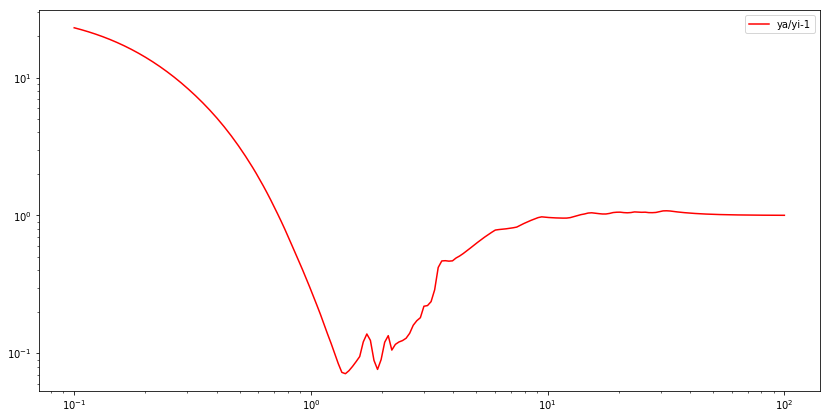

In [8]:
l_a = []
f_a = []
g_a = []
h_a = []

for l in np.geomspace (1.0e-1, 1.0e2, 200): #Return numbers spaced evenly on a log scale (a geometric progression).Starts at 0.1, stops in 100, and there are 200 numbers
    interp.set_over_smooth (l)
    interp.prepare_interp (Ncm.Vector.new_array (y_a))
    yi_a = [] 
    ya_a = []
    yi_b = []

    for x in xn_a:
        mset.fparams_set_array (x)
        fdata.prepare (mset)
        yi_a.append (interp.eval_m2lnp (Ncm.Vector.new_array (x)))
        ya_a.append (fdata.m2lnL_val (mset))

    yi_a = np.array (yi_a)
    ya_a = np.array (ya_a)

    m = -np.average (yi_a - ya_a, weights = 1.0 / ya_a**2)
    diff = (yi_a + m) / ya_a - 1.0 #untill here is the same as calib function, but we are using different values for the smooth property
    diff2 = (yi_a + m) - ya_a #dif multiplied by the data
    
    l_a.append (l)
    f_a.append (np.sqrt (np.sum (diff2**2)/len(diff2)))
    g_a.append (np.sqrt (np.sum (diff **2)/len(diff ))) #we create lists for each result for each smoothness. l = value of smooth, f = sqrt of diff, and g = sqrt of diff2 


plt.figure (figsize=(14, 7))
#plt.plot (l_a, f_a, 'b-', label='ya-yi')
plt.plot (l_a, g_a, 'r-', label='ya/yi-1') # we are plotting y=g_a versus x=l_a. According to the graph, the best smoothness is between 0 and 10(log l = 1)
plt.legend(loc='best')

plt.xscale ('log')
plt.yscale ('log')


In [9]:
#interp.prepare ()
interp.set_over_smooth (calib_os['x'][0])# I dont really get how this works. I think this especifies the function calib, saying to minimize for the value x and to start with 0
#interp.set_over_smooth (1.0e-10)
interp.prepare_interp (Ncm.Vector.new_array (y_a)) #new interpolation for the optimized smoothness by calib_os

m:  0.336027092433
1.1e-01
4.8e-02
0.075
[ 0.3623467  -0.80684507  0.36833979  0.35262007  0.35619659  0.42932927
  0.34863761  0.36588199  0.36437836  0.34968823  0.36967414  0.35130844
  0.3536521   0.36664095  0.4302436   0.3644695   0.43405533  0.39193405
  0.35234852  0.3861634   0.35022586  0.0215029   0.36258454  0.35773197
  0.0582608  -0.11614126  0.38499475  0.34685773  0.24364236 -1.89432605
  0.45010889 -0.06237511  0.39828727 -1.3177563   0.4236922   0.43475647
  0.35915467  0.41075124  0.41385154  0.3582825   0.39434361  0.36598139
  0.36243221  0.38289972  0.38769025  0.41524118  0.41836202  0.35682521
  0.35483696  0.36690135  0.49384339 -1.10114107  0.39686051  0.35400949
  0.3696418   0.42305294  0.38540647  0.36939975  0.39071767  0.39309937
  0.39195282  0.35791355  0.43092814  0.47948511 -0.11977009  0.39448224
  0.39937566  0.3680782  -0.17033462  0.40010555  0.37066251 -1.02920356
  0.10975796  0.42980799  0.35897757 -0.57572965  0.39543679  0.36340879
  0.350556

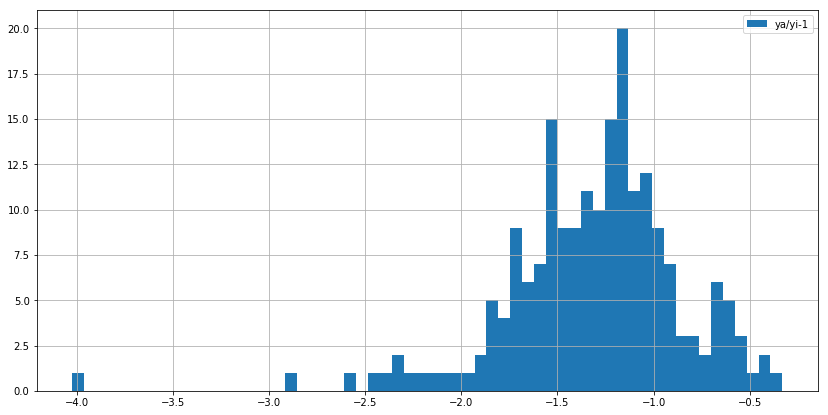

In [10]:
       
yi_a = []
ya_a = []
yi_b = []

for x in xn_a:
    mset.fparams_set_array (x)
    fdata.prepare (mset)
    yi_a.append (interp.eval_m2lnp (Ncm.Vector.new_array (x)))
    ya_a.append (fdata.m2lnL_val (mset))

yi_a = np.array (yi_a)
ya_a = np.array (ya_a)

m = -np.average (yi_a - ya_a, weights = 1.0 / ya_a**2)
print ("m: ", m)
diff = (yi_a + m) / ya_a - 1.0
diff2 = (yi_a + m) - ya_a

norm, cont = scipy.stats.mode (diff) #returns the modal and the number of times
plt.figure (figsize=(14, 7))

bla = plt.hist(np.log10 (np.abs(diff )), bins = 60, label='ya/yi-1')
#bla = plt.hist(np.log10 (np.abs(diff2)), bins = 60, label='ya-yi')
#bla = plt.hist(ya_a,     bins = 60, label='ya')
#bla = plt.hist(yi_a + m, bins = 60, label='yi')
#plt.yscale ('log')
plt.grid ()
plt.legend(loc='best')

mean_err = 10**(np.mean (np.log10 (np.abs (diff)))) # mean error

print ("%.1e" % (np.sqrt (np.sum(diff**2)/len(diff))))
print ("%.1e" % (mean_err))
print (sum(np.abs ((yi_a + 0.68486113) / ya_a - 1.0) < mean_err)/len(ya_a))

print (yi_a-ya_a+0.68486113)

#print (sum (np.abs((yi_a+m)/ya_a-1.0) < 1.0e-7)/len(ya_a))


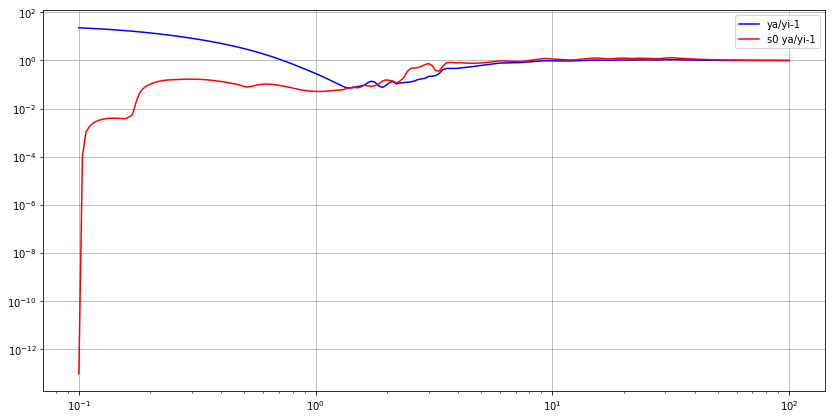

In [11]:
l0_a = []
f0_a = []
g0_a = []
#I dont see the difference between here and the other part where we did the same calculation. Why are the values different? It's because you used set_oversmooth(calib_os)? But here we always call oversmooth again. I dont get it.
for l in np.geomspace (1.0e-1, 1.0e2, 200):
    interp.set_over_smooth (l)
    interp.prepare_interp (Ncm.Vector.new_array (y_a))
    yi_a = []
    ya_a = []
    yi_b = []

    for x in x_a:
        mset.fparams_set_array (x)
        fdata.prepare (mset)
        yi_a.append (interp.eval_m2lnp (Ncm.Vector.new_array (x)))
        ya_a.append (fdata.m2lnL_val (mset))

    yi_a = np.array (yi_a)
    ya_a = np.array (ya_a)

    m = -np.average (yi_a - ya_a, weights = 1.0 / ya_a**2)
    diff = (yi_a + m) / ya_a - 1.0
    diff2 = (yi_a + m) - ya_a
    
    l0_a.append (l)
    f0_a.append (np.sqrt (np.sum (diff2**2)/len(diff2)))
    g0_a.append (np.sqrt (np.sum (diff **2)/len(diff )))


plt.figure (figsize=(14, 7))
plt.plot (l_a, g_a, 'b-', label='ya/yi-1')
plt.plot (l0_a, g0_a, 'r-', label='s0 ya/yi-1')
plt.legend(loc='best')
plt.grid()

plt.xscale ('log')
plt.yscale ('log')
